In [28]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run runme_terminus_sensitivity_basic.m translted from Matlab to Python
# Mikayla Pascual 01/03/23
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

import matplotlib as plt

In [2]:
# Load some .mat files to use later
vel_mat = loadmat('Cheat_matfiles/vel.mat')
hmaxVertices_mat = loadmat('Cheat_matfiles/hmaxVertices.mat')
param_mat = loadmat('Cheat_matfiles/param.mat')

velx = vel_mat['velx']
vely = vel_mat['vely']
vel = vel_mat['vel']

hmaxVertices = hmaxVertices_mat['hmaxVertices']

In [3]:
# Setup
region = 'SAtoES'
start_year = 1985

# Mesh sizing
triangleresolution = 1000
hmin = 300
hmax = 10000

# Mesh
md = model()
md = triangle(md,'./Exp/' +region+ '.exp',triangleresolution)
md = bamg(md, 'hmin', hmin, 'hmax', hmax, 'field', vel, 'err', 2, 'hmaxVertices', hmaxVertices)

#from savemodel import *
#savemodel(md,'./Models/' +region+ '_mesh.mat')
          

Anisotropic mesh adaptation

   new number of triangles = 24063


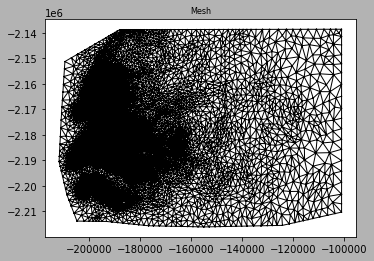

In [4]:
# Plot mesh
plotmodel(md, 'data', 'mesh')

In [24]:
## Inversion
md = loadmodel('./Models/' +region+ '_inversion.nc');

# Control general
md.inversion=m1qn3inversion();
md.inversion.iscontrol=1;
md.verbose.solution = False
md.verbose.control = True
param_mat = loadmat('Cheat_matfiles/param.mat')

# Load and convert param_mat values
md.geometry.thickness = param_mat['geometry_thickness']
md.geometry.bed = param_mat['geometry_bed']
md.geometry.surface = param_mat['geometry_surface']
md.geometry.base = param_mat['geometry_base']
md.mask.ice_levelset = param_mat['mask_ice_levelset']
md.mask.groundedice_levelset = param_mat['mask_groundedice_levelset']
md.inversion.vx_obs = param_mat['inversion_vx_obs']
md.inversion.vy_obs = param_mat['inversion_vy_obs']
md.inversion.vel_obs = param_mat['inversion_vel_obs']
md.initialization.vx = param_mat['initialization_vx']
md.initialization.vy = param_mat['initialization_vy']
md.initialization.vz = param_mat['initialization_vz']
md.initialization.vel = param_mat['initialization_vel']
md.friction.coefficient = param_mat['friction_coefficient']
md.materials.rheology_n = param_mat['rheology_n']
md.materials.rheology_B = param_mat['rheology_B']
md.basalforcings.groundedice_melting_rate = param_mat['basalforcings_groundedice_melting_rate']
md.basalforcings.floatingice_melting_rate = param_mat['basalforcings_floatingice_melting_rate']
md.smb.mass_balance = param_mat['smb_mass_balance']
md.basalforcings.geothermalflux = param_mat['basalforcings_geothermalflux']
md.stressbalance.spcvx = param_mat['stressbalance_spcvx']
md.stressbalance.spcvy = param_mat['stressbalance_spcvy']
md.stressbalance.spcvz = param_mat['stressbalance_spcvz']
md.stressbalance.referential = param_mat['stressbalance_referential']
md.stressbalance.loadingforce = param_mat['stressbalance_loadingforce']
md.masstransport.spcthickness = param_mat['masstransport_spcthickness']


# Cost functions
md.inversion.cost_functions=[101, 103, 501]; #Abs, Log, reg
md.inversion.cost_functions_coefficients=np.ones([md.mesh.numberofvertices,len(md.inversion.cost_functions)]);
md.inversion.cost_functions_coefficients[:,0]=2000;
md.inversion.cost_functions_coefficients[:,1]=40;
md.inversion.cost_functions_coefficients[:,2]=1.6e-06;

# Where vel==0, set coefficients to 0 (i.e., don't try to match this in model
#disp(['Removing vel==0 obs from inversion']);
#pos = find(md.inversion.vel_obs == 0);
#md.inversion.cost_functions_coefficients(pos,1) = 0;
#md.inversion.cost_functions_coefficients(pos,2) = 0;

# Controls
md.inversion.control_parameters=['FrictionCoefficient'];
md.inversion.maxsteps=50;
md.inversion.maxiter =50;
md.inversion.min_parameters=0.05*np.ones(md.mesh.numberofvertices);
md.inversion.max_parameters=200*np.ones(md.mesh.numberofvertices);
md.inversion.control_scaling_factors=1;

# Set basal friction coefficient initial guess to something low at front
#filename = 'Exp/' +region+ '_coeffront.exp';
#if os.path.isfile(filename):
  #disp(['Correcting basal friction coefficient initial guess for front inconsistencies']);
 # flags = ContourToNodes(md.mesh.x,md.mesh.y,filename,2);
  #flags = md.inversion.vel_obs == 0;
  #pos1 = np.where(flags)[0];
  #pos2 = np.where(~flags);
  #md.friction.coefficient[pos1]=10;
  #md.inversion.max_parameters[pos1]= md.friction.coefficient[pos1]


#Additional parameters
md.stressbalance.restol=0.01;
md.stressbalance.reltol=0.1;
md.stressbalance.abstol=np.nan;
#md.stressbalance.requested_outputs={'default','DeviatoricStressxx','DeviatoricStressyy','DeviatoricStressxy'}

# Go solve
md.verbose.solution=1;
from socket import gethostname
from generic import generic
md.cluster = generic('name', gethostname(), 'np', 4)
md.settings.waitonlock = np.inf
md.cluster.interactive = 0
md = solve(md,'Stressbalance');

# Save
from export_netCDF import export_netCDF
export_netCDF(md, "filename")

Opening ./Models/SAtoES_inversion.nc for reading 
empty init
empty init
checking model consistency
marshalling file SAtoES.bin
uploading input file and queueing script
launching solution sequence on remote cluster
waiting for /efs/issm-new/python-modules/repos/trunk-jpl-working/execution/SAtoES-02-08-2023-15-33-41-414/SAtoES.lock hold on... (Ctrl+C to exit)
loading results from cluster
WARNING type "int16" is unknown for "mask.ice_levelset"
WARNING type "uint8" is unknown for "basalforcings.groundedice_melting_rate"
WARNING type "uint8" is unknown for "basalforcings.floatingice_melting_rate"
WARNING type "uint8" is unknown for "materials.rheology_n"
WARNING type "uint8" is unknown for "initialization.vz"
field md.solidearth.external is None
WARNING type "uint8" is unknown for "stressbalance.loadingforce"
qmu is skipped until it is more stable


/efs/issm-new/python-modules/repos/trunk-jpl-working/src/m/contrib/defleurian/netCDF/export_netCDF.py:394: RuntimeWarning: invalid value encountered in remainder
  IsInt = np.sum(np.mod(var, 1)) == 0 and np.all(abs(var) < 2147483647) and len(var) > 0


In [23]:
param_mat['inversion_vx_obs']

array([[ -67.54424787],
       [   7.05344267],
       [   0.        ],
       ...,
       [ -90.86700005],
       [-588.7962334 ],
       [   0.        ]])

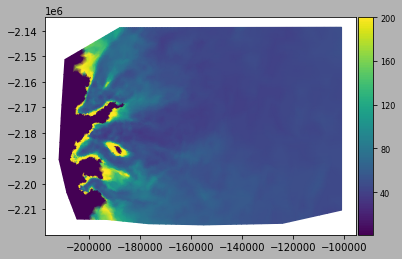

In [30]:
#fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', md.friction.coefficient)